# Analysis of Fifa 18 Ultimate Team Players' Data

The data used in this notebook is a fork from a repository - "kafagy95/fifa18-Data" -  with the description:

>- The purpose of this repository is to have a script that autoamtically pulls down all players data from Futhead's website

The data used was extracted on 7 January 2018. We will play around with the data and tell a story using the CSV file.

In [54]:
from __future__ import division, absolute_import
from warnings import filterwarnings
filterwarnings('ignore')

# The usual suspects ...
import os
import numpy as np
import pandas as pd
import missingno as msn
import scipy as sc
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import hypertools as hyp
import plotly as py

# And their accomplices ...
py.offline.init_notebook_mode(connected=True)
from ggplot import*
from plotly.graph_objs import*
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage, inconsistent, fcluster
from scipy.spatial.distance import pdist

# Plotting settings
%matplotlib inline
sns.set_style('whitegrid')
np.set_printoptions(precision=5, suppress=True)
#plt.style.use('fivethirtyeight')

Now we import the data.

In [55]:
# Importing the data
data = os.path.join('fifa18.csv')
assert os.path.isfile(data)
df = pd.read_csv(data, index_col=False)
df.shape

(10000, 11)

The dataset has 10000 rows and 11 columns. Now we want to get a feel of what the data looks like. Let's display the first few rows.

In [56]:
df.head(10)

Name                 Club            League Position  Rating  \
0   Cristiano Ronaldo       Real Madrid CF  LaLiga Santander       LW      94   
1        Lionel Messi         FC Barcelona  LaLiga Santander       RW      93   
2              Neymar  Paris Saint-Germain           Ligue 1       LW      92   
3         Luis Suárez         FC Barcelona  LaLiga Santander       ST      92   
4              Neymar  Paris Saint-Germain           Ligue 1       LW      92   
5  Robert Lewandowski   FC Bayern MÃ¼nchen        Bundesliga       ST      91   
6       Sergio Agüero      Manchester City    Premier League       ST      90   
7          Toni Kroos       Real Madrid CF  LaLiga Santander       CM      90   
8     Gonzalo Higuaín             Juventus          Calcio A       ST      90   
9        Sergio Ramos       Real Madrid CF  LaLiga Santander       CB      90   

   Pace  Shooting  Passing  Dribbling  Defending  Physical  
0    90        93       82         90         33        80  
1    89        90       86         95         26        61  
2    92        84       79         94         30        60  
3    82        90       79         86         42        81  
4    92        84       79         94         30        60  
5    81        88       75         86         38        82  
6    88        90       77         90         24        74  
7    50        81       88         81         73        70  
8    79        87       70         83         25        74  
9    76        63       71         72         88        83

The data has 11 columns with the following descriptions:

>- Name - the name of the player
>- Club - the name of the player's club
>- League - the name of the club's league
>- Position - the player's position
>- Rating - the player's overall rating
>- Pace - the player's relative pace
>- Shooting - the player's relative shooting ability
>- Passing - the player's relative passing ability
>- Dribbling - the player's relative dribbling skill
>- Defending - the player's relative defending ability
>- Physical - the player's relative physical ability (e.g., aggression, stamina, endurance etc.)

Let's find out if our dataset has any missing values.

## Are there any missing values in our data?

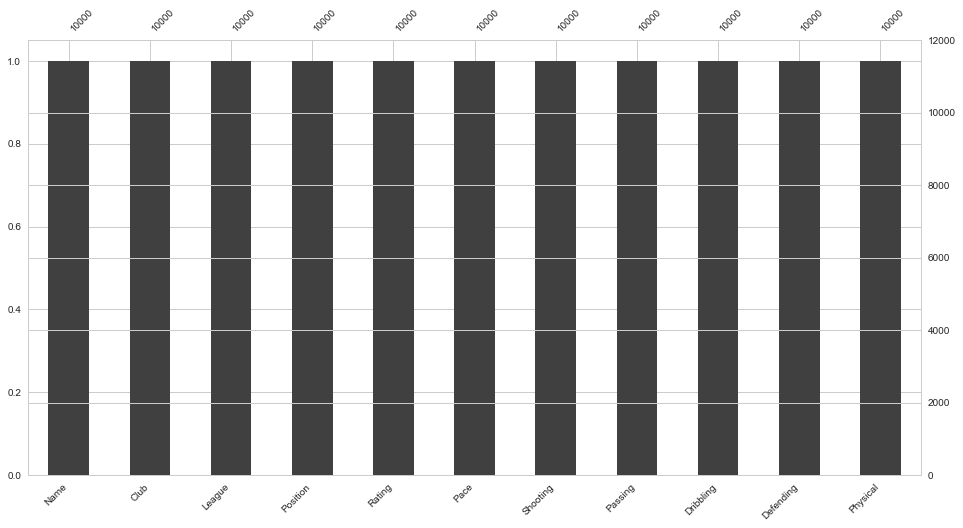

In [57]:
# Missing data for each columns
msn.bar(df, figsize=(16, 8), fontsize=10)

Let's count the number of unique values in each column.

## Are there any duplicate entries in our data?

In [58]:
# Defining our function to print the unique values in each column
def unique_value_counts(dataframe):
    '''Prints the unique value counts for each column.'''
    cols = (x for x in dataframe.columns)
    try:
        while True:
            field = cols.__next__()
            print('='*75,
                  '\n Field: ', field, '\n\n',
                  dataframe[field].unique(), '\n',
                 '='*75, '\n')
    except StopIteration:
        print('Done.')
        
# Printing unique values
unique_value_counts(df)

 Field:  Name 

 ['Cristiano Ronaldo' 'Lionel Messi' 'Neymar' ..., 'Didier Lamkel Ze'
 'Nadjack' 'David Stec'] 

 Field:  Club 

 ['Real Madrid CF' 'FC Barcelona' 'Paris Saint-Germain' 'FC Bayern MÃ¼nchen'
 'Manchester City' 'Juventus' 'Chelsea' 'Arsenal' 'Milan'
 'AtlÃ©tico Madrid' 'Manchester United' 'Borussia Dortmund' 'Napoli'
 'Tottenham Hotspur' 'Tigres U.A.N.L.' 'BeÅŸiktaÅŸ JK'
 'AS Monaco Football Club SA' 'Liverpool' 'Inter' 'Roma' 'FC Porto'
 'Villarreal CF' 'FenerbahÃ§e SK' 'Athletic Club de Bilbao' 'Atalanta'
 'Olympique de Marseille' 'Sporting CP' 'OGC Nice' 'SL Benfica' 'Lazio'
 'Sevilla FC' 'RC Celta de Vigo' 'Everton' 'Leicester City' 'RB Leipzig'
 'Valencia CF' 'Torino' 'Southampton' 'AS Saint-Ã‰tienne' 'UD Las Palmas'
 'Real Betis BalompiÃ©' 'Shakhtar Donetsk' 'Lokomotiv Moscow'
 'Spartak Moscow' 'Toronto FC' 'New York City Football Club'
 'Zenit St. Petersburg' 'Real Sociedad' 'SV Werder Bremen'
 'Bayer 04 Leverkusen' 'Borussia MÃ¶nchengladbach' 'VfL Wolfsburg'
 'FC 

There don't seem to be any obvious duplicate entries, neither does our dataset contain any missing values except for the position attribute which has a 'None' placeholder. We likely won't spend a lot of time in cleaning it, but we should be cautious of other placeholder values and bad entries in the data. 

Let's see what we can learn about the position placeholder value 'None' and which players it is attached to.

In [59]:
position_placeholder = df.loc[(df.Position.str.contains('None'))]
position_placeholder.shape

(74, 11)

There are 74 players whose position is recorded with a placeholder. 

## Where do these players play, or where are they from?

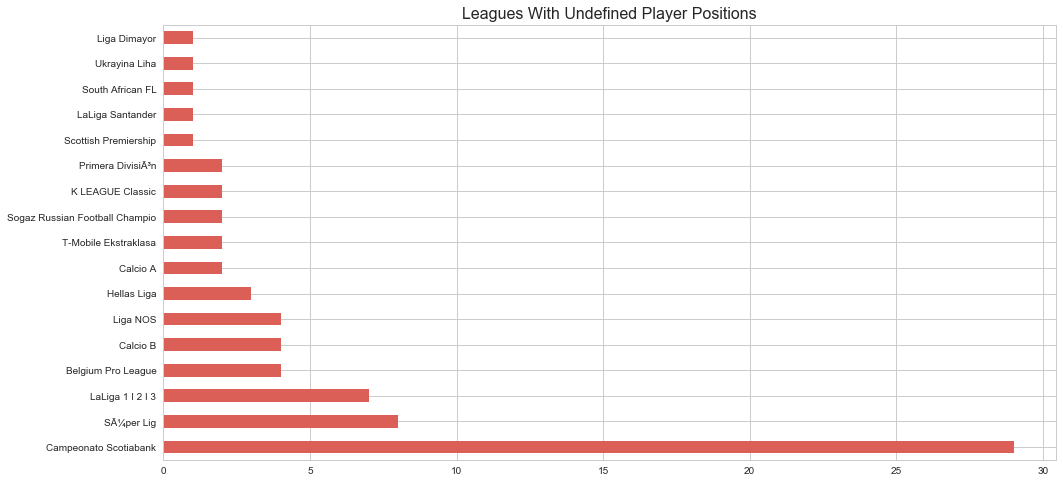

In [60]:
# League
plt.title('Leagues With Undefined Player Positions', fontsize=16)
position_placeholder.League.value_counts().plot.barh(figsize=(16, 8))

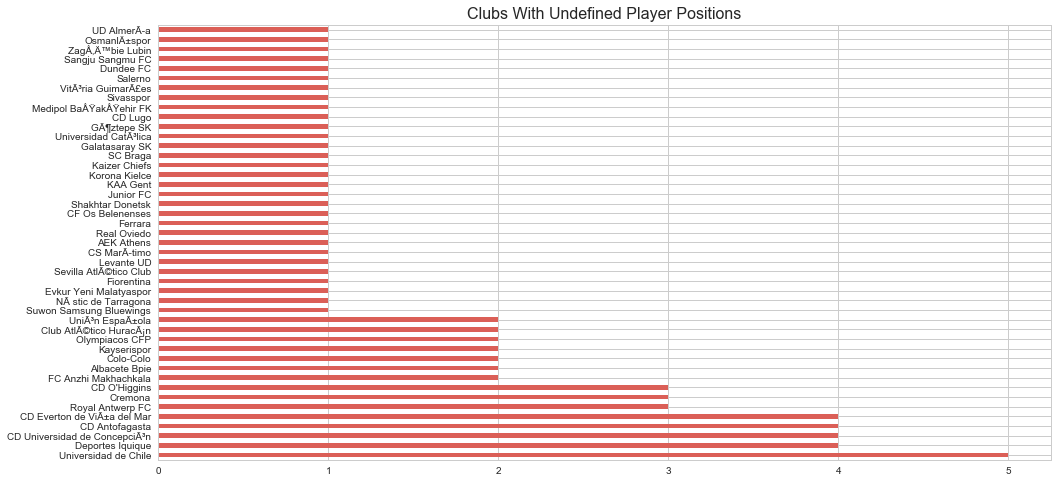

In [61]:
# Club
plt.title('Clubs With Undefined Player Positions', fontsize=16)
position_placeholder.Club.value_counts().plot.barh(figsize=(16, 8))

The players with no defined playing positions don't seem to come from top tier leagues or popular clubs and they make up less than 1% (0.074%) of the our data. We can neglect them without loss of accuracy in our data, so we'll remove them from our dataset.

In [62]:
df = df.loc[(~df.Position.str.contains('None'))]
df.shape

(9926, 11)

We will now go on to explore it and see what interesting insights we can find.

## What does our data look like?

In [63]:
t0 = Scatter3d(
    x=df.Pace,
    y=df.Shooting,
    z=df.Passing,
    mode='markers',
    marker=dict(
        size=5,
        color=df.Passing,
        colorscale='Virdis',
        opacity=.8
        )
    )
data = [t0]
layout = Layout(title='Visualizing Pace, Shooting, and Passing',
                #xaxis=dict(title='Pace', titlefont=dict(size=18, color='black')),
                #yaxis=dict(title='Shooting', titlefont=dict(size=18, color='black'))
               )
fig = Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='attributes-3d-scatter-2')

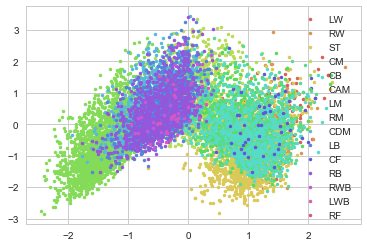

In [64]:
# Flattening to 2 dimensions
hyp.plot(df, '.', group=df.Position, legend=[i for i in df.Position.unique()], ndims=2)

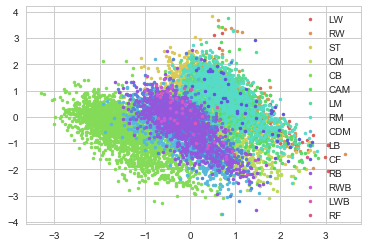

In [65]:
# Normalizing across
hyp.plot(df, '.', group=df.Position, legend=[i for i in df.Position.unique()], normalize='across', ndims=2)

In [66]:
df.describe()

Rating         Pace     Shooting     Passing    Dribbling  \
count  9926.000000  9926.000000  9926.000000  9926.00000  9926.000000   
mean     70.130465    69.077070    55.739573    60.79589    65.367620   
std       4.863787    12.013343    13.773811     9.50482     9.491492   
min      63.000000    23.000000    14.000000    27.00000    29.000000   
25%      66.000000    63.000000    46.000000    55.00000    61.000000   
50%      69.000000    71.000000    59.000000    62.00000    67.000000   
75%      73.000000    77.000000    66.000000    67.00000    71.000000   
max      94.000000    96.000000    93.000000    89.00000    95.000000   

         Defending     Physical  
count  9926.000000  9926.000000  
mean     53.686480    68.245315  
std      17.687219     8.459342  
min      15.000000    32.000000  
25%      36.000000    63.000000  
50%      61.000000    69.000000  
75%      68.000000    74.000000  
max      90.000000    92.000000

From basics measures of central tendency, we can see that:

>- the average overall player rating is 70.1%, with a minimum of 63.0% and a maximum of 94.0%. This gives us an indication as to how we may compare the players.
>- the average player has a pace of 69.1%, while the slowest has a rate of 23.0% and the fastest has a rate of 96%.
>- the best shooter has an accuracy of 93.0%. There is a lot of variability in shooting ability with a standard deviation of 13.8 (second highest). This can be be seen by comparing the best shooter who has a rating of 93.0%, while the worst shooter a has a rating of 55.8%.
>- the average player has a passing accuracy of 60.8%, with a standard deviation of 9.5.
>- dribbling skills have an average of 65.4% with the best dribbler having a rating of 95.0%.
>- defending ability has the greatest variability, with the majority of players averaging 53.6% and a standard deviation of 17.7.
>- physical ability has low variability at 8.5. This could mean there are slight differences in physique between players.

Descriptive statistics do not tell us much about the data but they do give us a starting point and raises a few top level questions which could help our inquiry. With the low variability in physical ability, we may be tempted to ask what constitutes the ideal player in Fifa18? What sets them apart from the rest? This is bearing in mind that Fifa18 is an abstraction of nature (subject to some error) and nature tends to follow abstraction. We can then be able to see how the best player is rated as the best relative to other players.

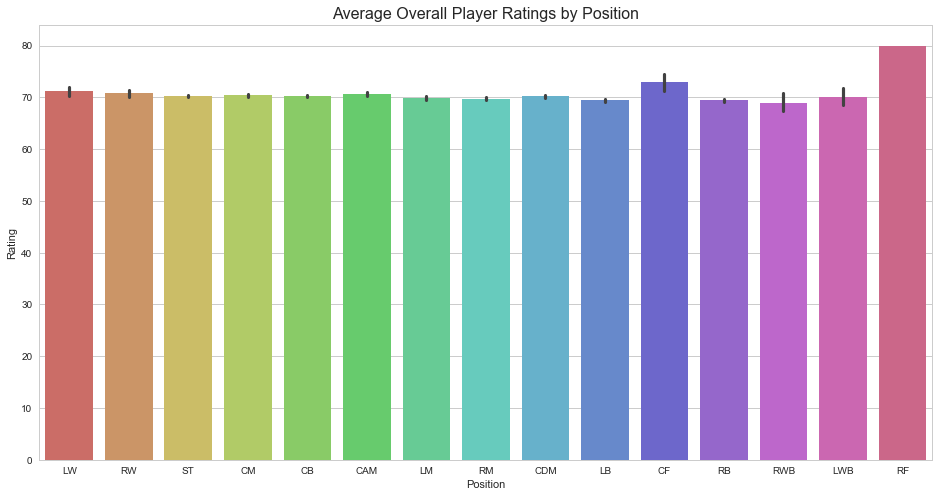

In [67]:
# Average overall player rating
plt.figure(figsize=(16, 8))
plt.title('Average Overall Player Ratings by Position', fontsize=16)
sns.barplot(x='Position', y='Rating', data=df)

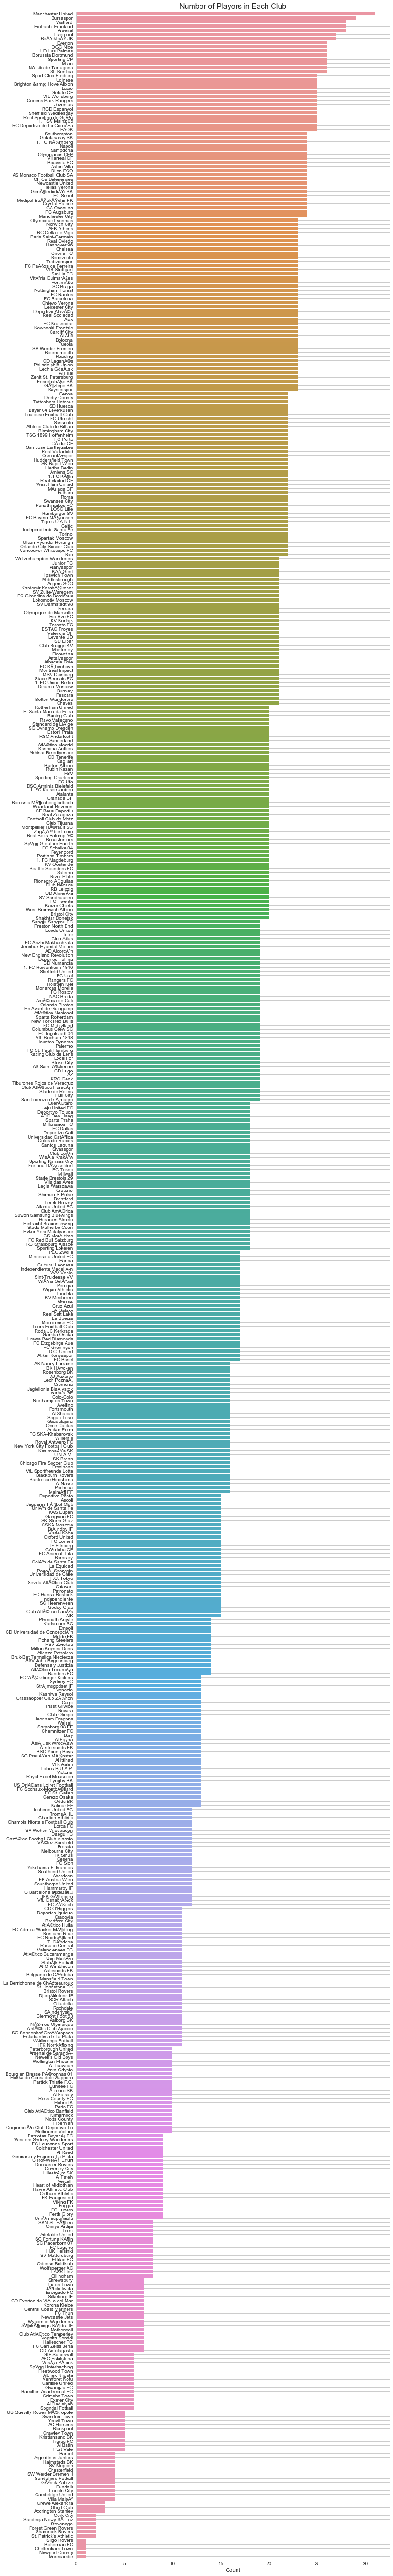

In [68]:
# Counting the number of players in each club
plt.figure(figsize=(12, 100))
plt.title('Number of Players in Each Club', fontsize=16)
sns.countplot(data=df, y='Club', order=df.Club.value_counts().index)
plt.xlabel('Count', fontsize=12)
plt.ylabel('')
plt.grid()

The club with the highest number of players is Manchester United with 31 players. This is followed by Bursaspor with 29. Arsenal, Watford, and Eintract Frankfurt all have 28 players. Clubs with the least number of players are Morecambe, Bohemian FC, Cheltenham Town, Sigo Rovers, and Newport County with 1 player each. 

The maximum squad line-up size in the English Premier League is 25 men, 8 of these must be home-grown talent, and the remaining 17 can be internationals. There are however no limits on under 21s. This could explain the player counts of clubs with more than 25 players where the "excess" could be under 21s. The perculiar cases are clubs with less than 11 men. These clubs do not constitute a complete team and cannot therefore be in a competitive league.

>- Could it be that the listed players in the clubs with less than 11 men are known players and the rest are placeholders to form a complete team?

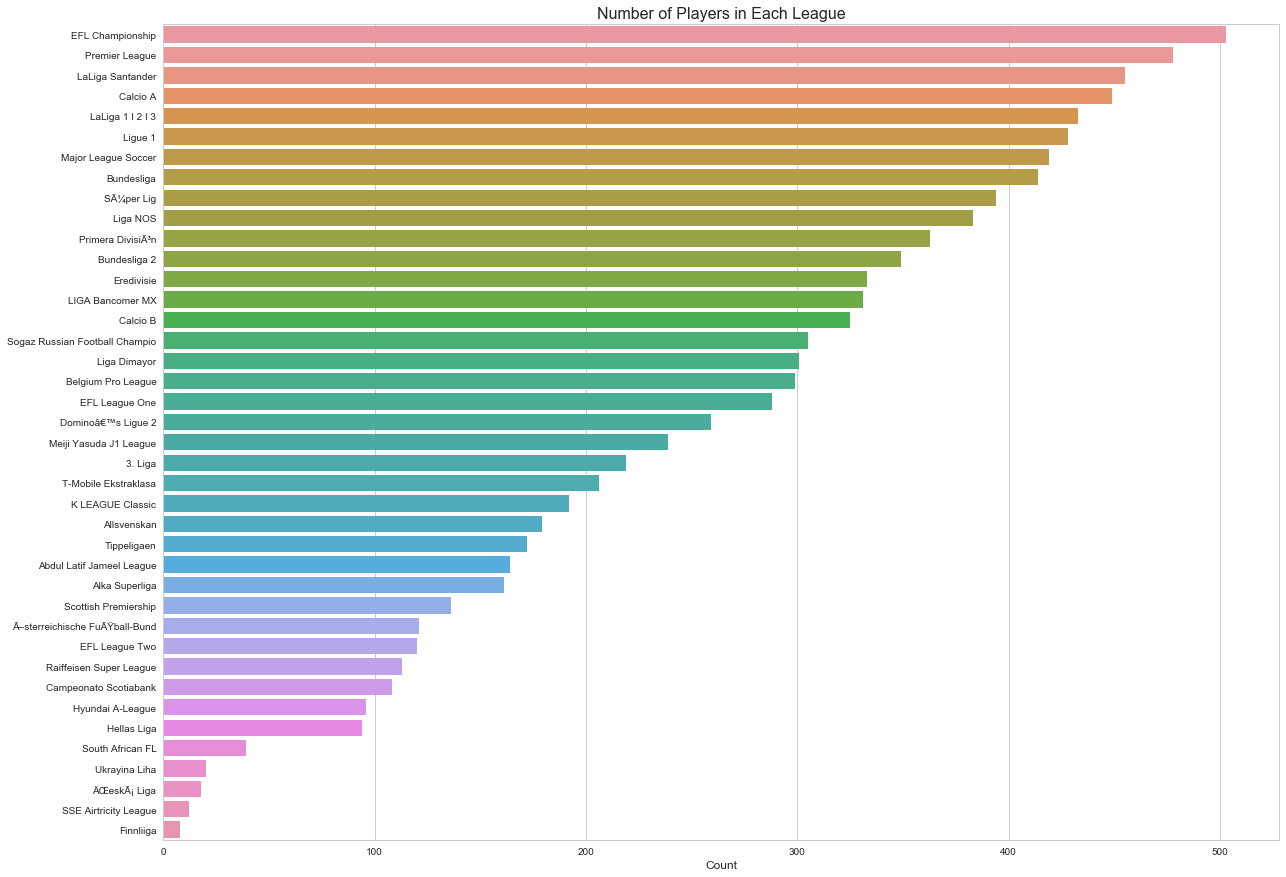

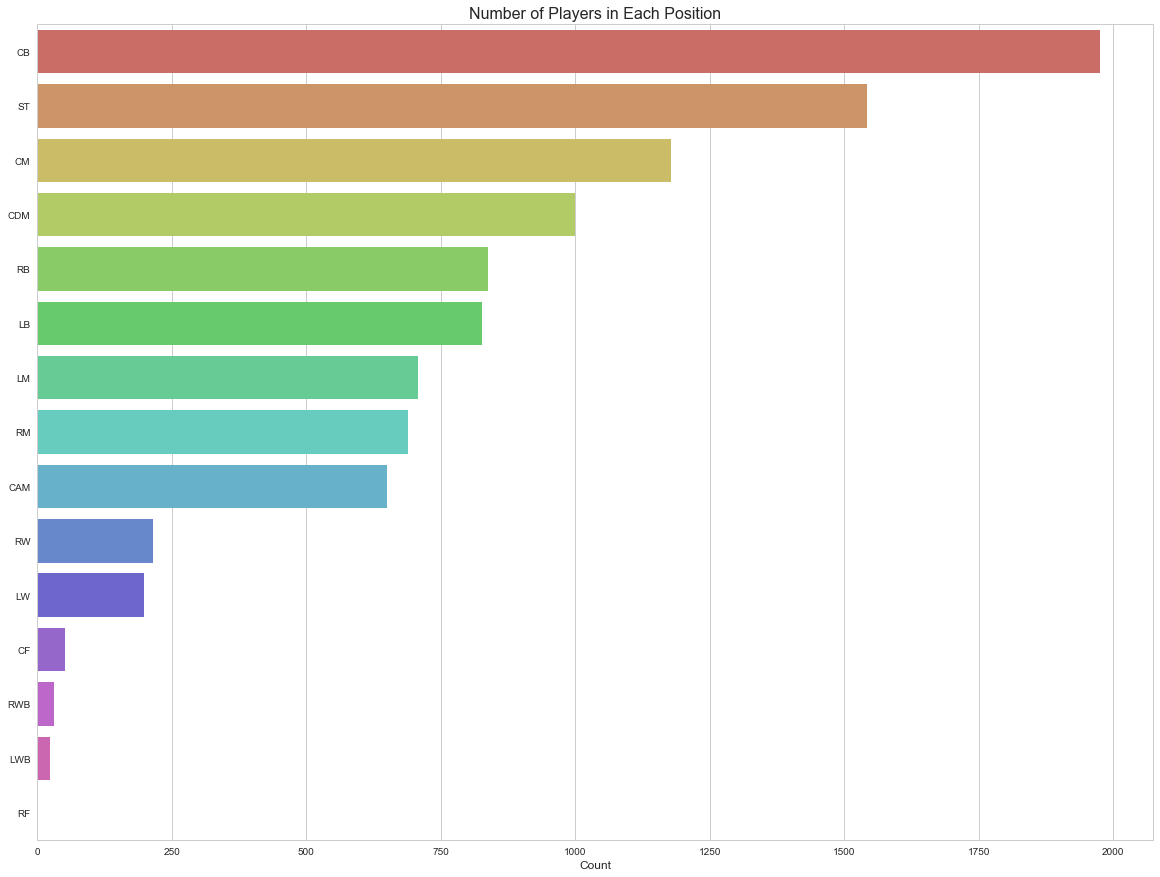

In [69]:
# Counting the number of players in each league and position
for value in ['League', 'Position']:
    plt.figure(figsize=(20, 15))
    plt.title('Number of Players in Each {}'.format(value), fontsize=16)
    sns.countplot(data=df, y=value, order=df[value].value_counts().index)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('')

The EFL Championship has the highest number of players, with over 500 listings. This is followed by the English Premier League, the Santander sponsored Spanish LaLiga, Calcio A, LaLiga 1|2|3, French Ligue 1, the North American Major League Soccer, and the German Bundesliga make complete the top eight represented leagues by number of total players.

Player position frequencies were:

>- Centre Back (CB) : 1976
>- Striker (ST) : 1543
>- Central Midfielder (CM) : 1178
>- Central Defensive Midfielder (CDM) : 999
>- Right Back (RB) : 838
>- Left Back (LB) : 826
>- Left Midfielder (LM) : 707
>- Right Midfielder (RM) : 689
>- Central Attacking Midfielder (CAM) : 650
>- Right Winger (RW) : 215
>- Left Winger (LW) : 199
>- Centre Forward (CF) : 52
>- Right Wing Back (RWB) : 30
>- Left Wing Back (LWB) : 23
>- Right Forward (RF) : 1

An interesting point to note with the positions is that the dataset consists only of out-field players. There are no goalkeepers included.

### Attribute Distributions

#### 1.  Rating

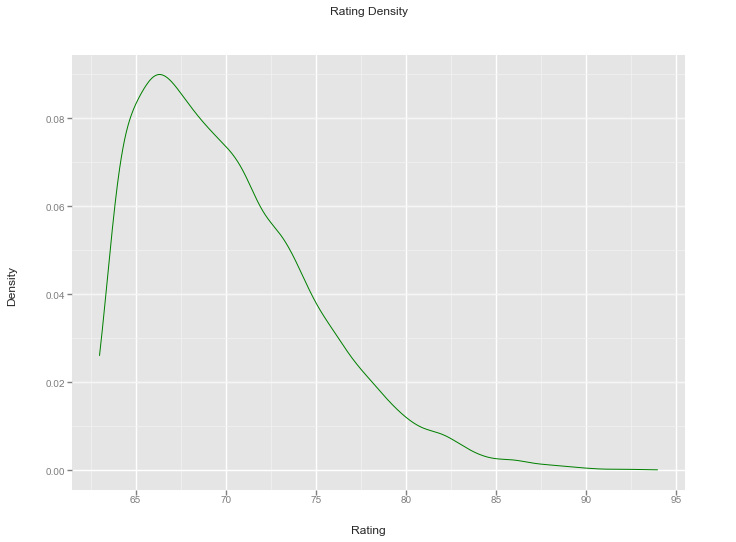

<ggplot: (-9223372036551901973)>

In [70]:
# Rating density
ggplot(aes(x='Rating'), df) + geom_density(color='Green') + labs(x='Rating', y='Density', title='Rating Density')

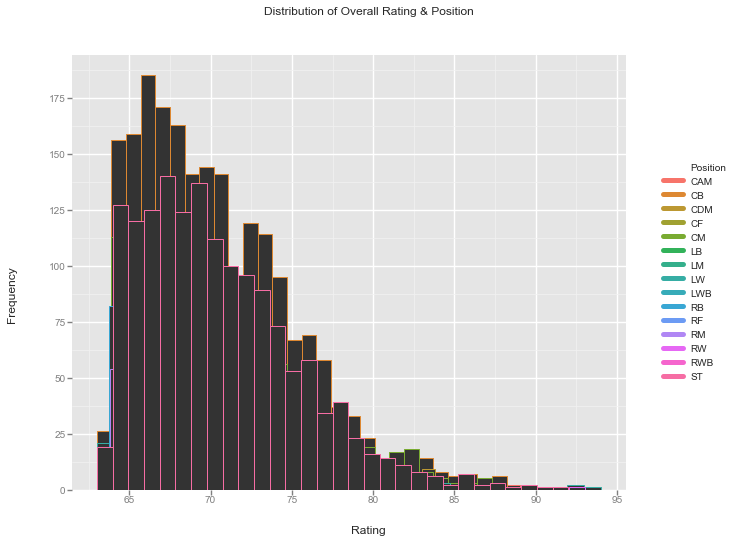

<ggplot: (-9223372036551862482)>

In [71]:
# Rating and position
ggplot(aes(x='Rating', color='Position'),df) + geom_histogram(bins=30) + labs(
    x='Rating', y='Frequency', title='Distribution of Overall Rating & Position')

#### 2. Pace

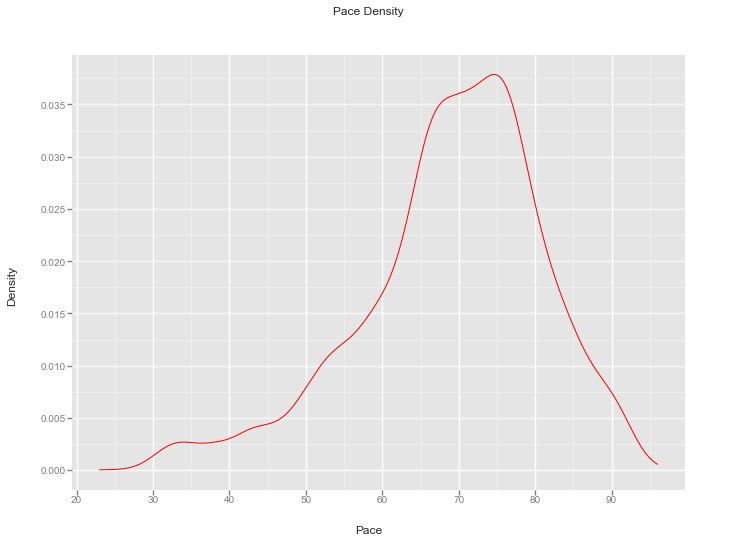

<ggplot: (-9223372036556681528)>

In [72]:
# Pace density
ggplot(aes(x='Pace'), df) + geom_density(color='Red') + labs(x='Pace', y='Density', title='Pace Density')

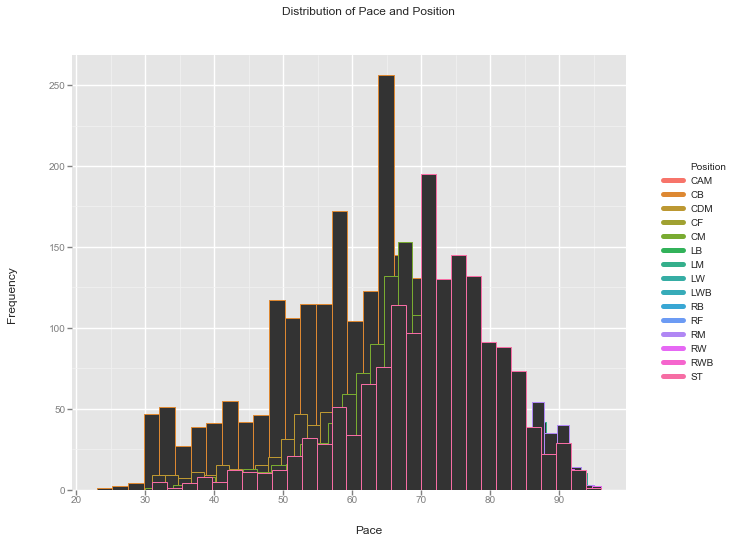

<ggplot: (295130530)>

In [73]:
# Pace and position
ggplot(aes(x='Pace', color='Position'), df) + geom_histogram(bins=30) + labs(
    x='Pace', y='Frequency', title='Distribution of Pace and Position')

#### 3. Shooting

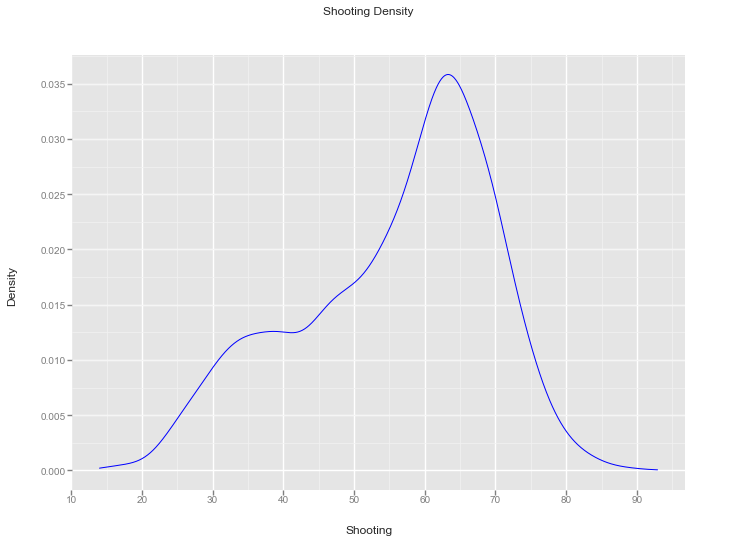

<ggplot: (-9223372036556801946)>

In [74]:
# Shooting density
ggplot(aes(x='Shooting'), df) + geom_density(color='Blue') + labs(x='Shooting', y='Density', title='Shooting Density')

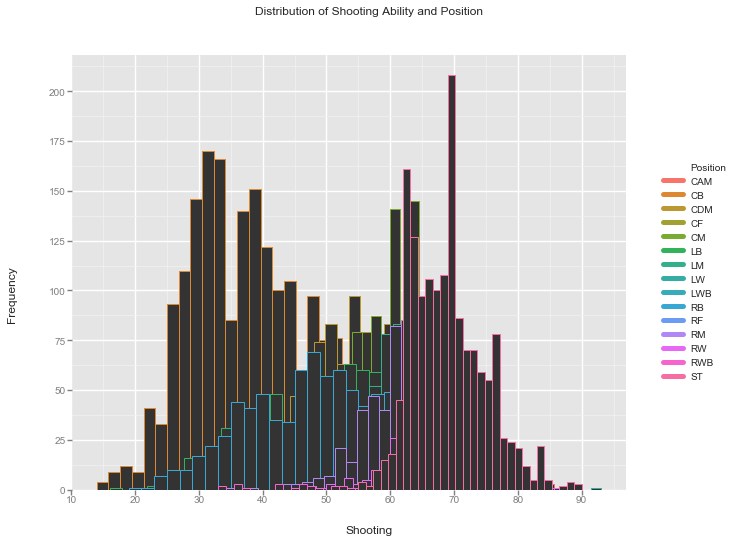

<ggplot: (-9223372036558148436)>

In [75]:
# Shooting and position
ggplot(aes(x='Shooting', color='Position'), df) + geom_histogram(bins=30) + labs(
    x='Shooting', y='Frequency', title='Distribution of Shooting Ability and Position')

#### 4. Passing

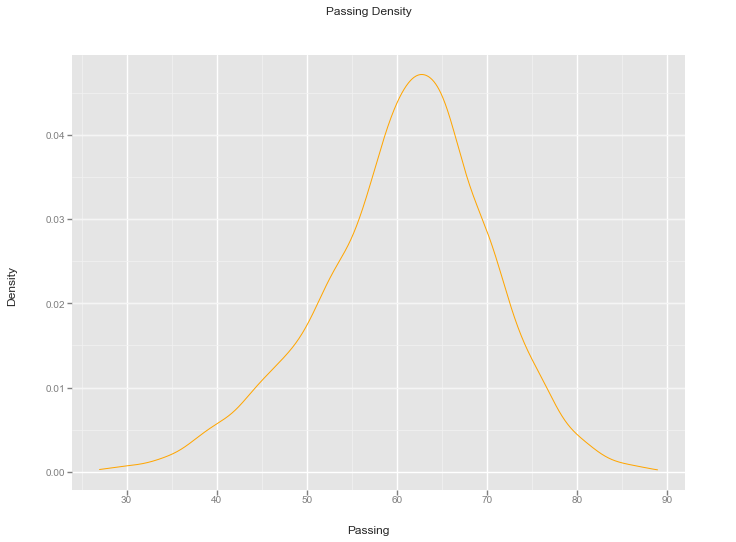

<ggplot: (296880048)>

In [76]:
# Passing density
ggplot(aes(x='Passing'), df) + geom_density(color='Orange') + labs(x='Passing', y='Density', title='Passing Density')

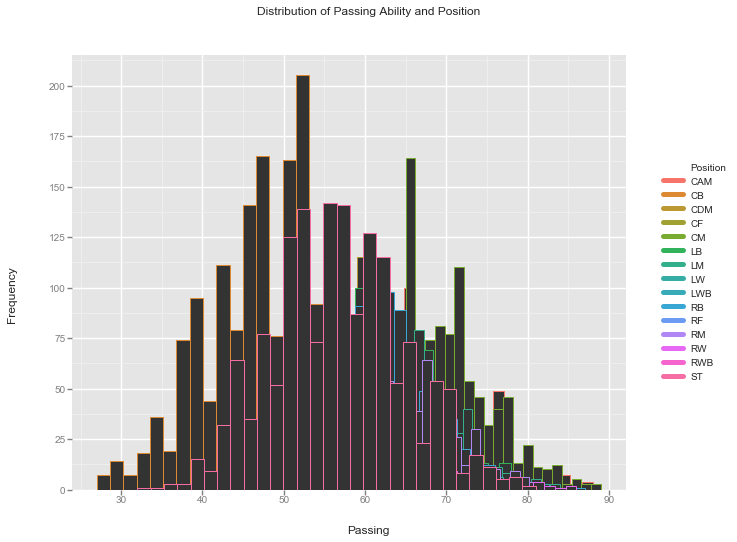

<ggplot: (305812828)>

In [77]:
# Passing and position
ggplot(aes(x='Passing', color='Position'), df) + geom_histogram(bins=30) + labs(
    x='Passing', y='Frequency', title='Distribution of Passing Ability and Position')

#### 5. Dribbling

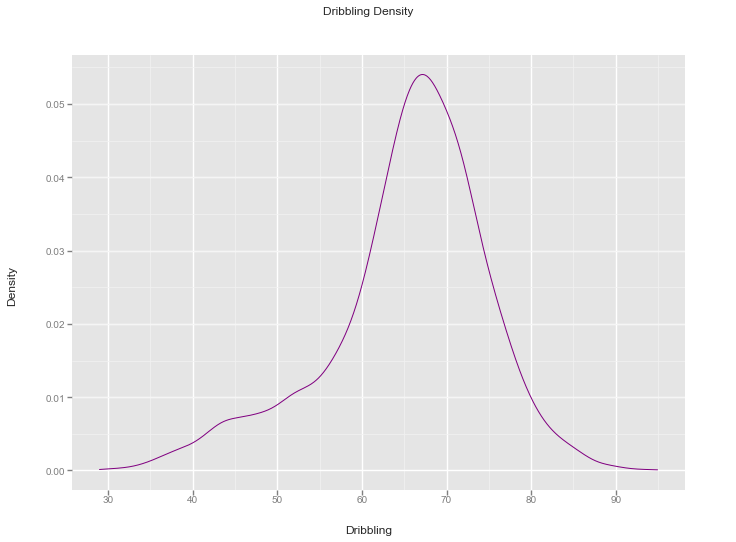

<ggplot: (-9223372036548729719)>

In [78]:
# Dribbling density
ggplot(aes(x='Dribbling'), df) + geom_density(color='Purple') + labs(
    x='Dribbling', y='Density', title='Dribbling Density')

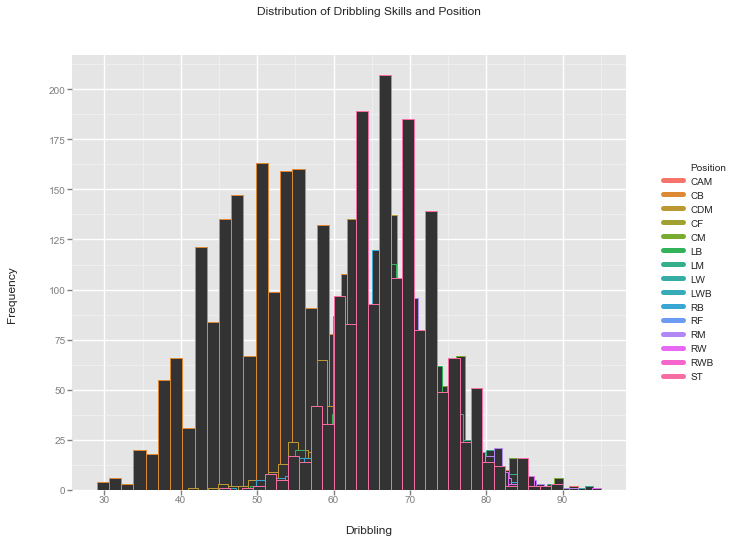

<ggplot: (306224725)>

In [79]:
# Dribbling and position
ggplot(aes(x='Dribbling', color='Position'), df) + geom_histogram(bins=30) + labs(
    x='Dribbling', y='Frequency', title='Distribution of Dribbling Skills and Position')

#### 6. Defending

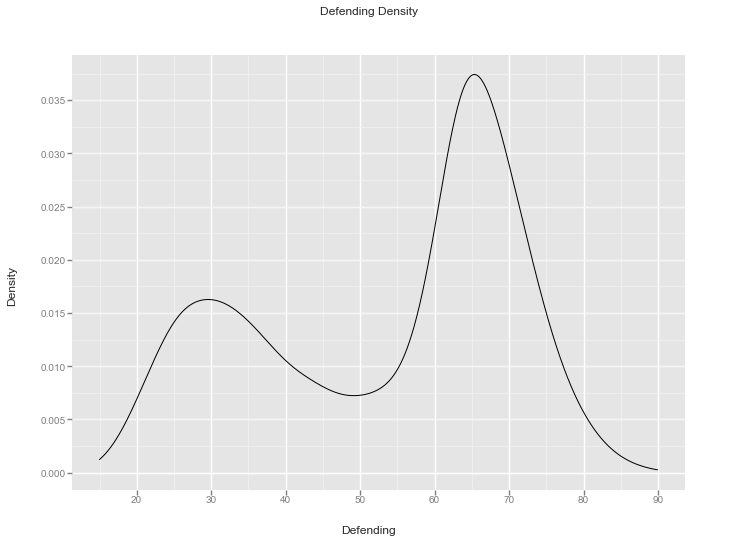

<ggplot: (-9223372036548397161)>

In [80]:
# Defending density
ggplot(aes(x='Defending'), df) + geom_density(color='Black') + labs(
    x='Defending', y='Density', title='Defending Density')

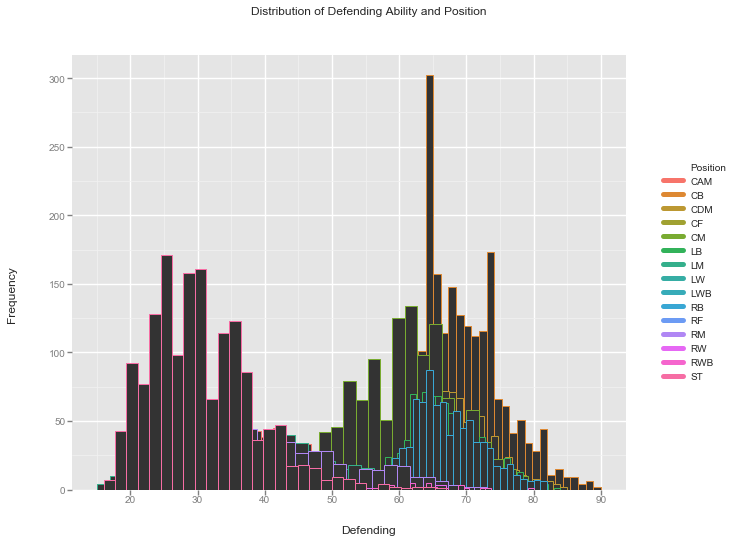

<ggplot: (-9223372036547573637)>

In [81]:
# Defending and position
ggplot(aes(x='Defending', color='Position'), df) + geom_histogram(bins=30) + labs(
    x='Defending', y='Frequency', title='Distribution of Defending Ability and Position')

#### 7. Physical

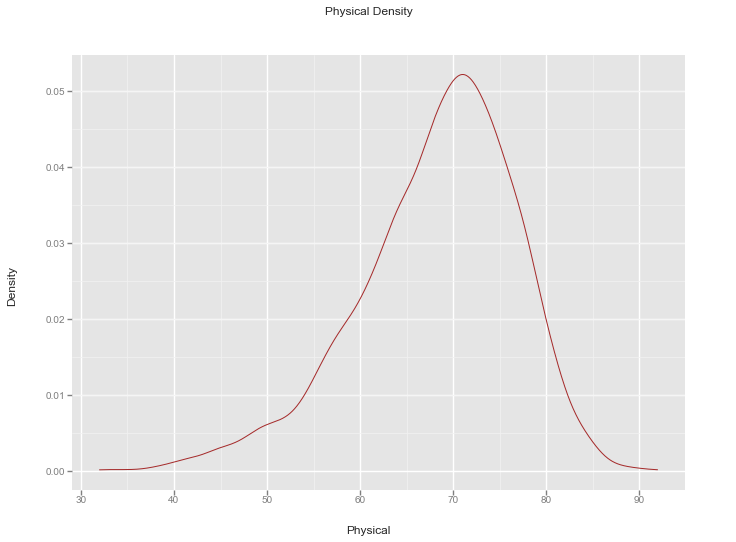

<ggplot: (302455286)>

In [82]:
# Physical density
ggplot(aes(x='Physical'), df) + geom_density(color='Brown') + labs(
    x='Physical', y='Density', title='Physical Density')

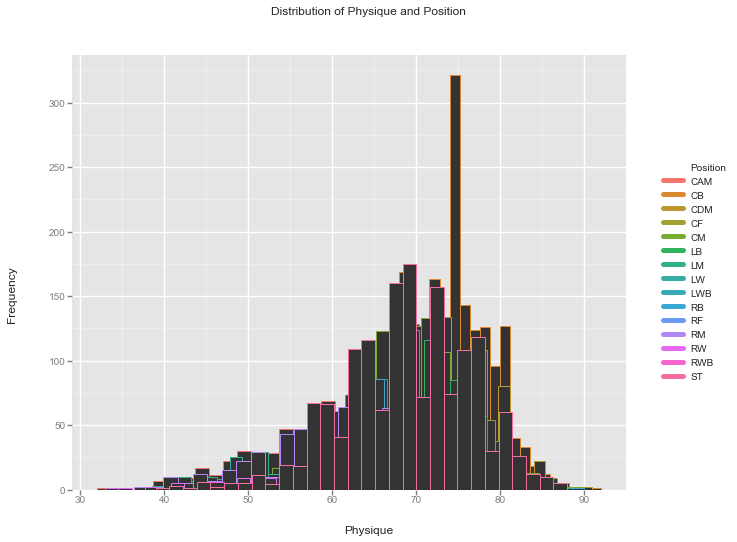

<ggplot: (306143159)>

In [83]:
# Physical and position
ggplot(aes(x='Physical', color='Position'), df) + geom_histogram(bins=30) + labs(
    x='Physique', y='Frequency', title='Distribution of Physique and Position')

The distribution of the data shows that the attributes follow a normal distribution.

### Testing and validating relationships between attributes

We'll start off by considering correlations between the attributes.

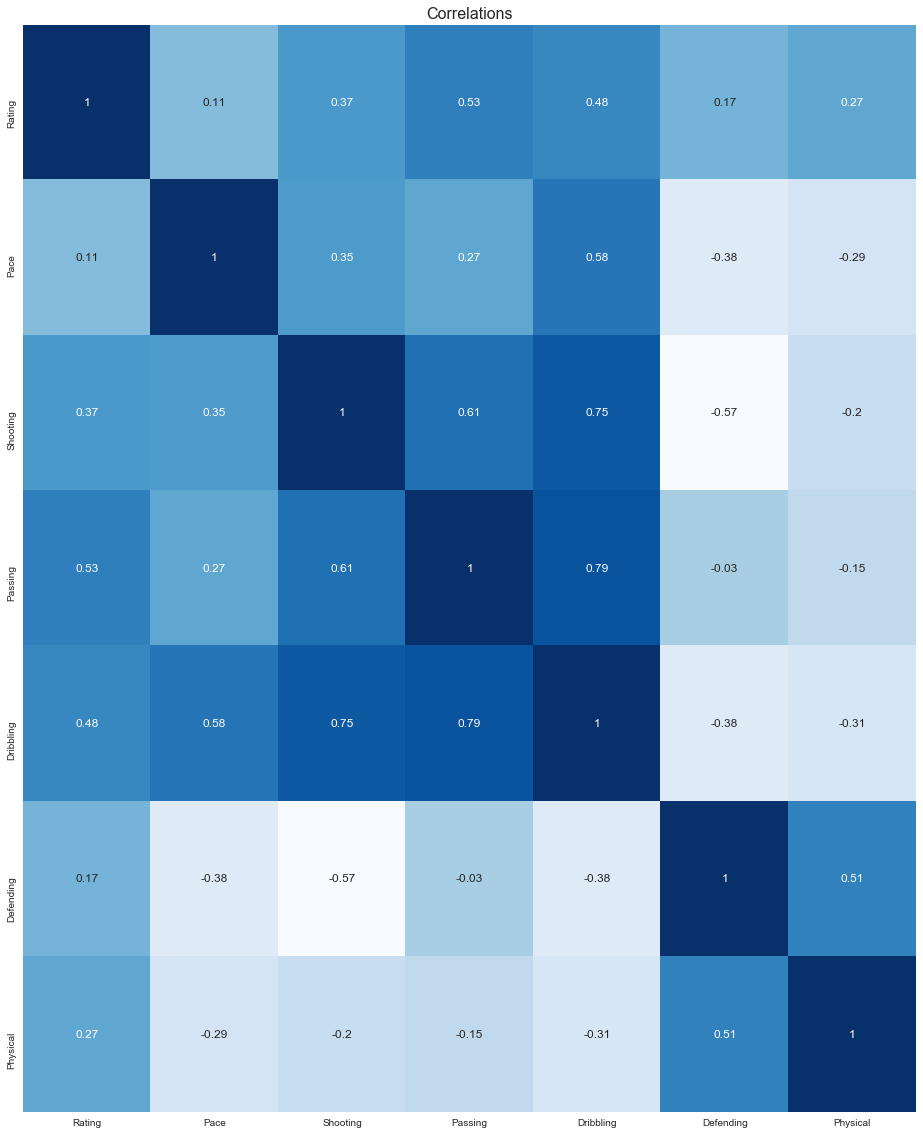

In [84]:
# Correlations
correlations = df.select_dtypes(include=['int64']).corr()
plt.figure(figsize=(16, 20))
plt.title('Correlations', fontsize=16)
sns.heatmap(correlations, annot=True, cbar=False, cmap='Blues')

When we look at the correlations between the different player attributes, we see interesting relationships, one of which is that there are negative correlations.

>- does this mean there are certain attributes that bring down the overall player rating?

**NB:** Keep in mind that 'correlation' does not imply 'cause', it merely suggests the existence (or non-existence) of a relationship.

#### More correlations

Let's have a deeper look at some interesting player attribute relationships.

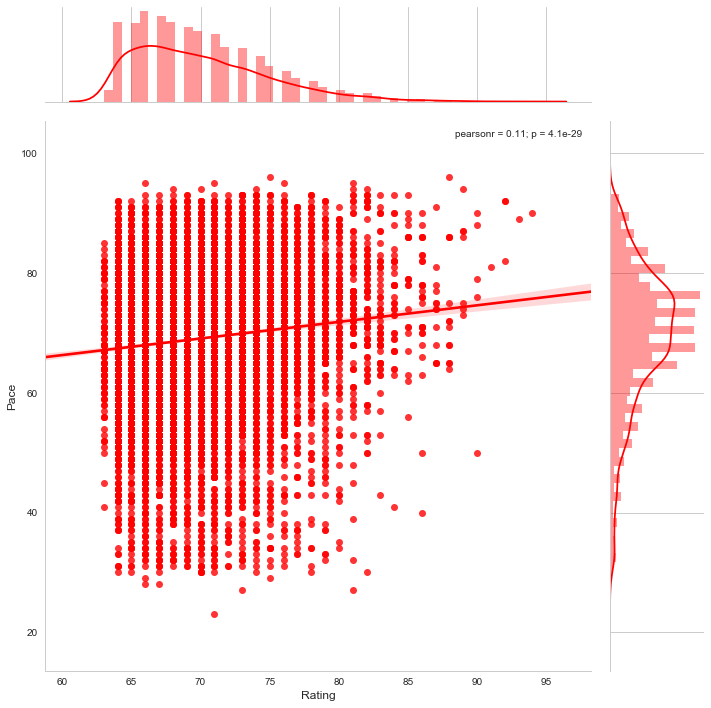

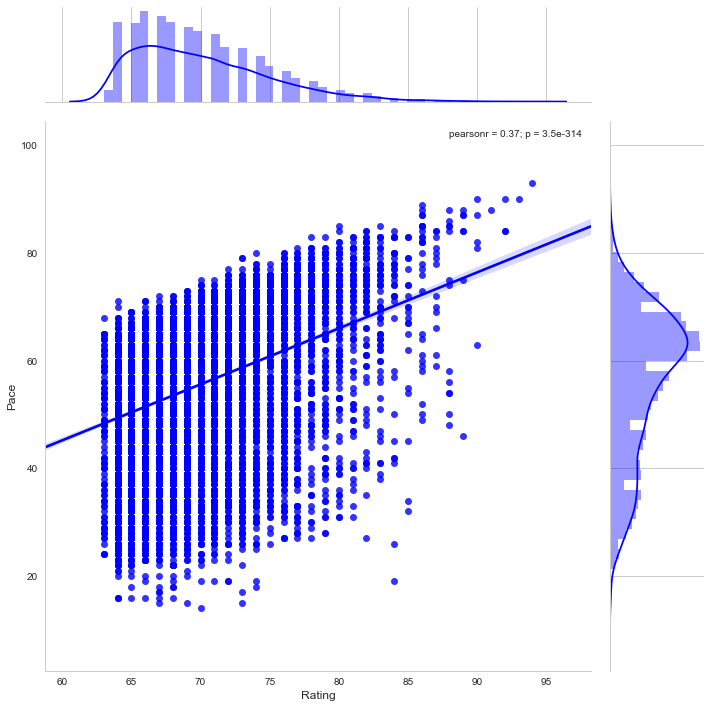

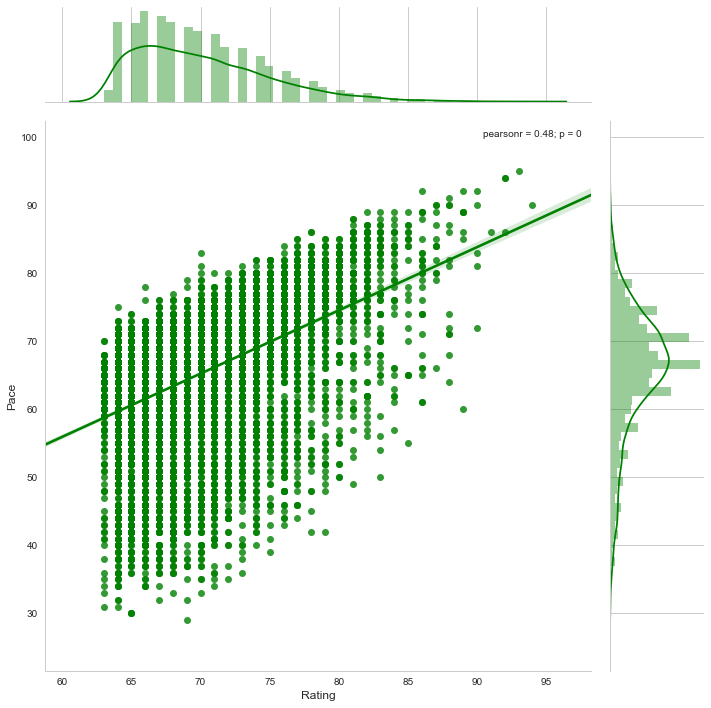

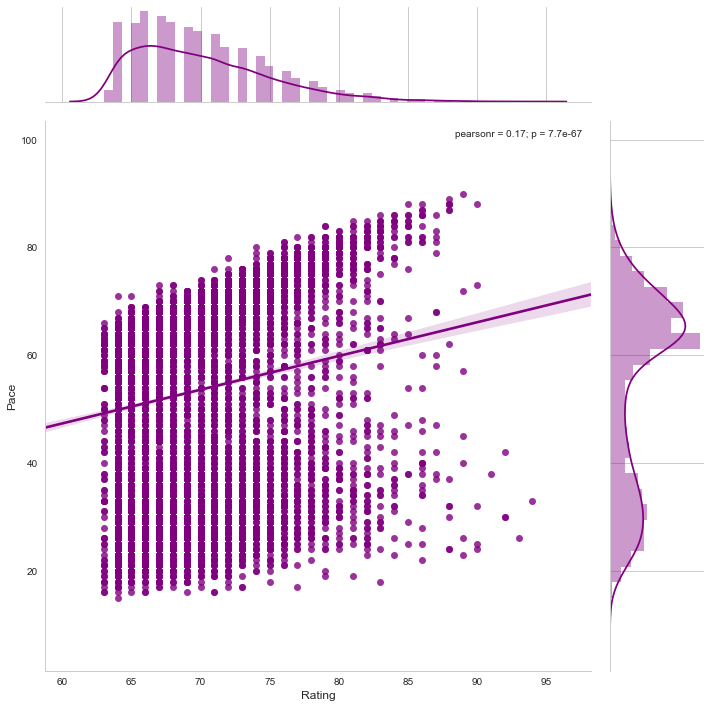

In [85]:
# Overall rating vs. Pace
for value in zip(['Pace', 'Shooting', 'Dribbling', 'Defending'], ['red', 'blue', 'green', 'purple']):
    column, color = value
    plt.figure(figsize=(16, 8))
    sns.jointplot('Rating', column, data=df, kind='reg', color=color, size=10)
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('Pace', fontsize=12)
    plt.grid()

There is a reasonably strong correlation between some of the attributes, but we have not learnt much about them. Now we want to go a bit further by inquiring further into established relationships. We'll use Welch's Test (similar to the Student's T-test but without comparing the variances, only the means) to answer some of the questions. This frequentist approach will solidify our understanding of the data and help us build our story.

#### 1. Are player ratings significantly different from 0?

In [86]:
for attribute in ['Rating', 'Pace', 'Shooting', 'Passing', 'Dribbling', 'Defending', 'Physical']:
    test = sc.stats.ttest_1samp(df[attribute], 0.0)
    print('='*55)
    print('Null Hypothesis: \tThe mean is equal to zero.\nAlternative Hypothesis:\tThe mean is not equal to zero.')
    print('Attribute: \t\t{0}\nTest Statistic: \t{1}\nAlpha (p-value): \t{2}'.format(attribute, test[0], test[1]))
    if (test[1] <= 0.00000001):
        print('Conclusion: \t\tMean is not equal to zero.')
    else:
        print('Conclusion: \t\tMean is equal to zero.')
    print('='*55, '\n')

Null Hypothesis: 	The mean is equal to zero.
Alternative Hypothesis:	The mean is not equal to zero.
Attribute: 		Rating
Test Statistic: 	1436.5451253691915
Alpha (p-value): 	0.0
Conclusion: 		Mean is not equal to zero.

Null Hypothesis: 	The mean is equal to zero.
Alternative Hypothesis:	The mean is not equal to zero.
Attribute: 		Pace
Test Statistic: 	572.8714417981788
Alpha (p-value): 	0.0
Conclusion: 		Mean is not equal to zero.

Null Hypothesis: 	The mean is equal to zero.
Alternative Hypothesis:	The mean is not equal to zero.
Attribute: 		Shooting
Test Statistic: 	403.1778447415688
Alpha (p-value): 	0.0
Conclusion: 		Mean is not equal to zero.

Null Hypothesis: 	The mean is equal to zero.
Alternative Hypothesis:	The mean is not equal to zero.
Attribute: 		Passing
Test Statistic: 	637.2611481637348
Alpha (p-value): 	0.0
Conclusion: 		Mean is not equal to zero.

Null Hypothesis: 	The mean is equal to zero.
Alternative Hypothesis:	The mean is not equal to zero.
Attribute: 		Dribbling

None of the attributes have a mean of 0. This is some assurance on the quality of our data and we can go ahead with our analysis.

#### 2. Is there statistical significance in a player's position in the field?

In [87]:
a = pd.Series(df.Position.value_counts())
test = sc.stats.ttest_1samp(a, 0)
print('='*55)
print('Null Hypothesis: \tThe mean is equal to zero.\nAlternative Hypothesis:\tThe mean is not equal to zero.')
print('Attribute: \t\tPosition\nTest Statistic: \t{0}\nAlpha (p-value): \t{1}'.format(test[0], test[1]))
if (test[1] <= 0.0):
    print('Conclusion: \t\tMean is not equal to zero.')
else:
    print('Conclusion: \t\tMean is equal to zero.')
print('='*55, '\n')

Null Hypothesis: 	The mean is equal to zero.
Alternative Hypothesis:	The mean is not equal to zero.
Attribute: 		Position
Test Statistic: 	4.299588507154463
Alpha (p-value): 	0.0007341279470589031
Conclusion: 		Mean is equal to zero.



The mean value for players positions has no significant difference from zero, and so we conclude that there is no statistical significance in a player's position in the field.

#### 3. Is there a statistical significance in overall rating and the other attributes (i.e., overall vs. pace, shooting, passing, dribbling, defending, and physical)?

To answer this question, we could use a 2 sample T-test but that would neglect the link between observations: all attributes are measured on the same individual players. To remove the confounding inter-subject variability, we'll use a paired T-test for repeated measures on the same individuals.

In [88]:
for attribute in ['Pace', 'Shooting', 'Passing', 'Dribbling', 'Defending', 'Physical']:
    test = sc.stats.ttest_rel(df['Rating'], df[attribute])
    print('='*100)
    print('Null Hypothesis: \tThe mean is equal to zero.\nAlternative Hypothesis:\tThe mean is not equal to zero.')
    print('Attributes: \t\tRating vs. {0}\nTest Statistic: \t{1}\nAlpha (p-value): \t{2}'.format(attribute, test[0], test[1]))
    if (test[1] <= 0.0):
        print('Conclusion: \t\tThere is no significant statistical difference between Rating and {}.'.format(attribute))
    else:
        print('Conclusion: \t\tThere is a significant statistical difference between Rating and {}.'.format(attribute))
    print('='*100, '\n')

Null Hypothesis: 	The mean is equal to zero.
Alternative Hypothesis:	The mean is not equal to zero.
Attributes: 		Rating vs. Pace
Test Statistic: 	8.432996917172508
Alpha (p-value): 	3.8382574734969704e-17
Conclusion: 		There is a significant statistical difference between Rating and Pace.

Null Hypothesis: 	The mean is equal to zero.
Alternative Hypothesis:	The mean is not equal to zero.
Attributes: 		Rating vs. Shooting
Test Statistic: 	111.88976927431442
Alpha (p-value): 	0.0
Conclusion: 		There is no significant statistical difference between Rating and Shooting.

Null Hypothesis: 	The mean is equal to zero.
Alternative Hypothesis:	The mean is not equal to zero.
Attributes: 		Rating vs. Passing
Test Statistic: 	115.08604454624371
Alpha (p-value): 	0.0
Conclusion: 		There is no significant statistical difference between Rating and Passing.

Null Hypothesis: 	The mean is equal to zero.
Alternative Hypothesis:	The mean is not equal to zero.
Attributes: 		Rating vs. Dribbling
Test Stat

Results from the test show us that:

>- There is a statistically significant difference between the rating and pace, as well as rating and physical.
>- There is no statistically significant difference between the rating and the rest of the attributes, namely, shooting, passing, dribbling, and defending.

From this we can infer that physical traits (pace and physical) are statistically significantly different from the overall rating of the player. The other attributes are statistically significantly not different from the overall rating. 

>- What attributes would be needed to define a player's overall ability?

From the correlations, the rating has the following correlations:

>- Pace : .11
>- Shooting : .37
>- Passing : .53
>- Dribbling: .48
>- Defending: .17
>- Physical: .27

There are high correlations (at least .40) between rating with passing (.53), and dribbling (.48). All other ratings have low correlations but none are negative. We will use Exploratory Factor Analysis (EFA) to examine which attributes are of greatest significance in the dataset.

In [89]:
data = df[['Pace', 'Shooting', 'Passing', 'Dribbling', 'Defending', 'Physical']]
pca = sk.decomposition.PCA(n_components=len(data.columns))
pca.fit(data)
for column in zip(data.columns, pca.explained_variance_ratio_):
    print('Component Name: \t{0}\nExplained Variance: \t{1}'.format(column[0], column[1]))

Component Name: 	Pace
Explained Variance: 	0.5660088026407661
Component Name: 	Shooting
Explained Variance: 	0.21314650860657308
Component Name: 	Passing
Explained Variance: 	0.12306957616952884
Component Name: 	Dribbling
Explained Variance: 	0.06448632537925772
Component Name: 	Defending
Explained Variance: 	0.02225825366859847
Component Name: 	Physical
Explained Variance: 	0.011030533535275748


(8, 20)

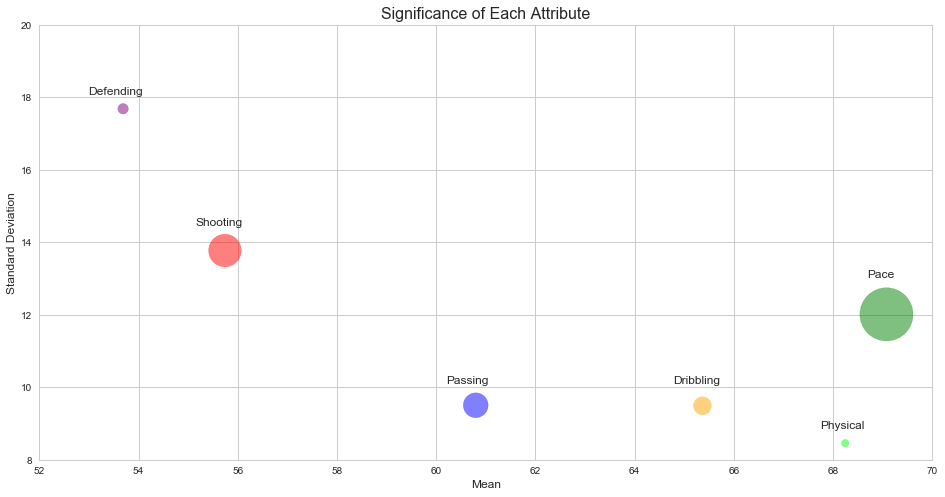

In [90]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1,1,1)
ax.scatter(x=data.mean(), y=data.std(), s=[i*5000 for i in pca.explained_variance_ratio_], 
           color=['green', 'red', 'blue', 'orange', 'purple', 'lime'], alpha=.5)
plt.title('Significance of Each Attribute', fontsize=16)
plt.xlabel('Mean', fontsize=12)
plt.ylabel('Standard Deviation', fontsize=12)
ax.text(data.mean()[0]-.4, data.std()[0]+1., 'Pace', size=12)
ax.text(data.mean()[1]-.6, data.std()[1]+.7, 'Shooting', size=12)
ax.text(data.mean()[2]-.6, data.std()[2]+.6, 'Passing', size=12)
ax.text(data.mean()[3]-.6, data.std()[3]+.6, 'Dribbling', size=12)
ax.text(data.mean()[4]-.7, data.std()[4]+.4, 'Defending', size=12)
ax.text(data.mean()[5]-.5, data.std()[5]+.4, 'Physical', size=12)
plt.xlim((52, 70))
plt.ylim((8, 20))

From the plot, we can see that pace has the greatest significance in the data. It has the greatest explained variance ratio, and mean. Physical has the second highest mean, the lowest standard deviation but the least explained variance ratio, while defending has the lowest mean and greatest standard deviation and is the second least significant attribute in the data. The mid-range consists of shooting, passing and dribbling.

The results show that the top 3 attributes needed to rate a player, or define a player's ability from the data are:

> 1. Pace
> 2. Shooting
> 3. Passing

in that order. Their dribbling skills or capacity to defend against the opposition or their physical ability are secondary in defining their overall skills in comparison to every other player. We can now see that the inclusion of goalkeepers would be justified since these primary skills are possessed by most football players, both out-field and goalkeepers.

### Clustering Players

To cluster our players, we'll use hierarchical clustering (HCA) which build a hierarchy of clusters.

In [91]:
# Hierarchical Clustering
X = df.select_dtypes(include=['int64'])
Z = linkage(X, 'ward')
c, coph_dists = cophenet(Z, pdist(X))
c

0.62881514874117872

We have a Cophenetic Correlation Coefficient of .63, which is close to 1 demonstrating that the clusters have preserved their original distances - so we can reasonably trust our results. 

We're now going to plot our dendogram. It will be truncated to show the point of best fit.

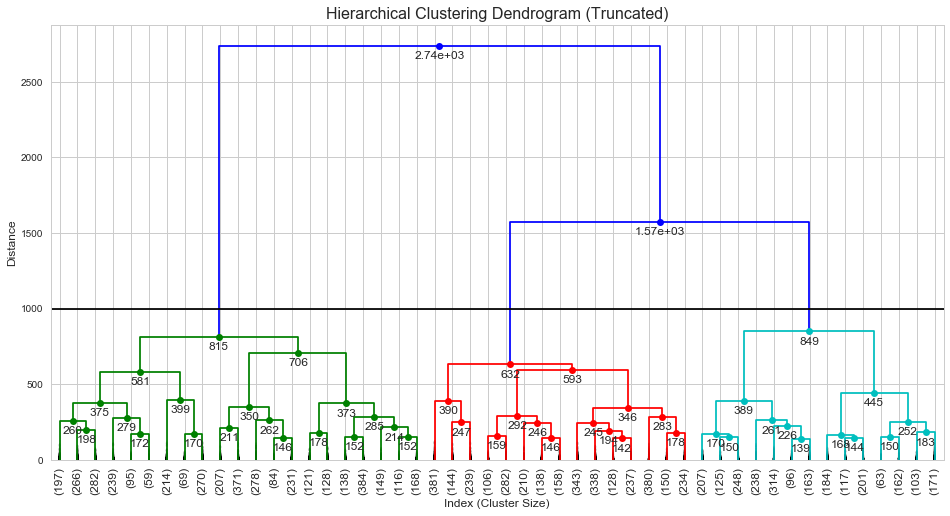

In [92]:
# Dendogram function
def fancy_dendogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    ddata = dendrogram(*args, **kwargs)
    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (Truncated)', fontsize=16)
        plt.xlabel('Index (Cluster Size)', fontsize=12)
        plt.ylabel('Distance', fontsize=12)
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = .5 * sum(i[1:3])
            y = d[1]
            if (y > annotate_above):
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                            va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

# Plotting
plt.figure(figsize=(16, 8))
fancy_dendogram(Z,
                truncate_mode='lastp',
                p=50,
                leaf_rotation=90.,
                leaf_font_size=12.,
                show_contracted=True,
                annotate_above=10,
                max_d=1000
               )
plt.show()

We set our cut-off at the point of 50 merges and observe that the greatest jump moves a distance of 1925 units before merging. We set the cut-off at 1000 because points lower than this give results that have small distances between suggesting a merge that should not have taken place. At this point we find that we have 3 clusters: green, red, and azure branches. 

The green branch contains 21 merges, red has 15 merges, and azure has 14 merges. If we also look at the cluster sizes, most of them seem to have a fairly comparable sample size (green = 815, red = 632, azure = 849).


#### Selecting a distane cut-off: Number of clusters
##### Elbow Method

The elbow method attempts to find the clustering step where the acceleration of distance growth is the greatest.

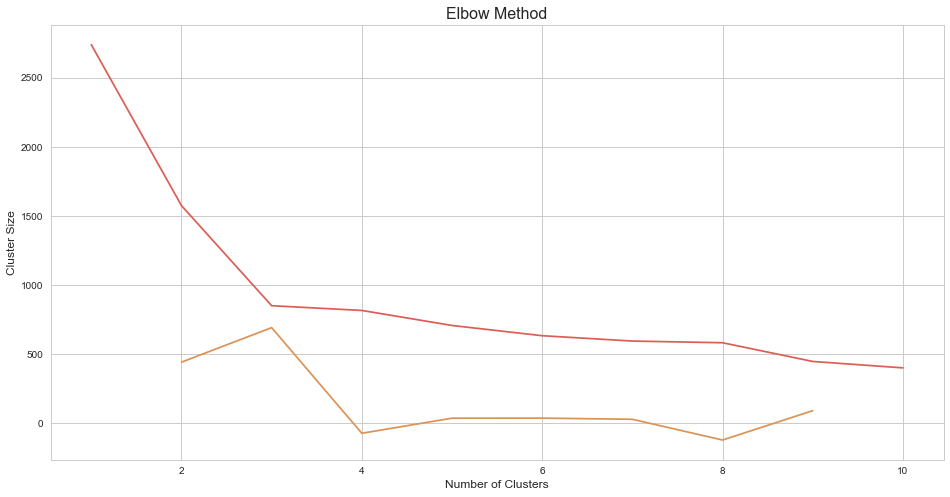

Clusters: 3


In [93]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.figure(figsize=(16, 8))
plt.title('Elbow Method', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Cluster Size', fontsize=12)
plt.plot(idxs, last_rev)
acceleration = np.diff(last, 2)
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2 # If idx 0 is the max, we want 2 clusters
print('Clusters: {}'.format(k))

#### Retrieving the clusters

We'll now retrieve the clusters.

##### Knowing max_d:

In [94]:
max_d = 1000
clusters = fcluster(Z, max_d, criterion='distance')
print(clusters)

[1 1 1 ..., 1 3 2]


##### Knowing k:

In [95]:
k = 3
print(fcluster(Z, k, criterion='maxclust'))

[1 1 1 ..., 1 3 2]


##### Inconsistency Method:

This is basically a guess.

In [96]:
print(fcluster(Z, 20, depth=10))

[1 1 1 ..., 1 3 2]


#### Visualizing our clusters

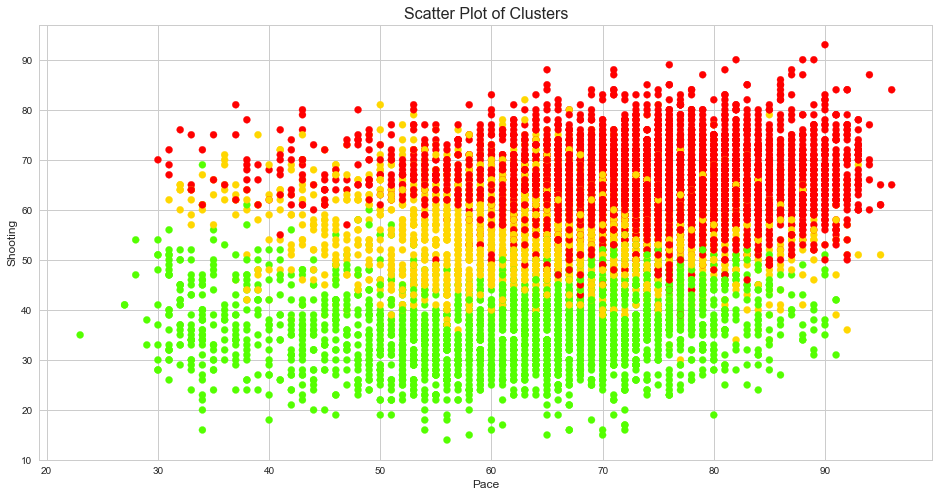

In [97]:
plt.figure(figsize=(16, 8))
plt.scatter(X.Pace, X.Shooting, c=clusters, cmap='prism')
plt.title('Scatter Plot of Clusters', fontsize=16)
plt.xlabel('Pace', fontsize=12)
plt.ylabel('Shooting', fontsize=12)
plt.show()

The data contains 3 clusters or distinct groups of players that appear more dependent on shooting ability than pace. This, as we have established earlier in our tests, does not depend on the players position. The distribution when considering pace and shooting splits the players into thresholds based on shooting: 

>- poor - low shooting ability
>- average - median shooting ability
>- good - high shooting ability

Most players are either good or poor at shooting with fewer players clustered as having average ability.

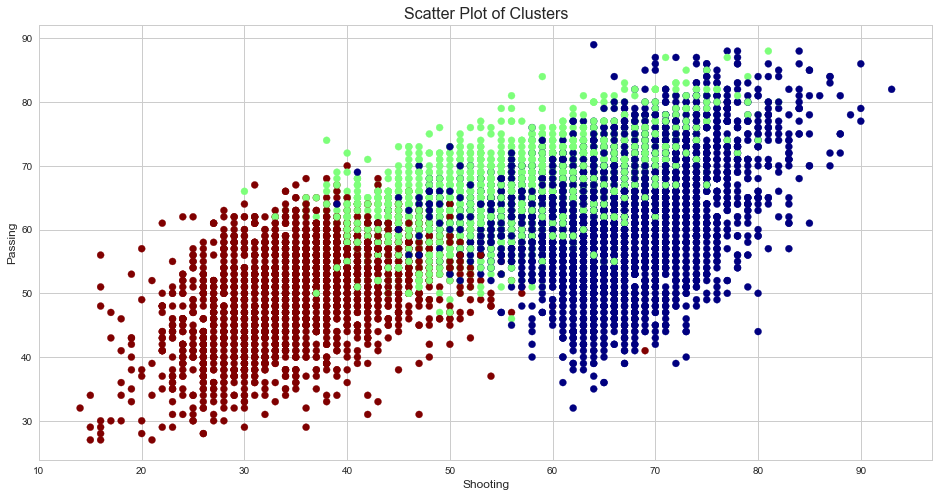

In [98]:
plt.figure(figsize=(16, 8))
plt.scatter(X.Shooting, X.Passing, c=clusters, cmap='jet')
plt.title('Scatter Plot of Clusters', fontsize=16)
plt.ylabel('Passing', fontsize=12)
plt.xlabel('Shooting', fontsize=12)
plt.show()

When we compare the clusters on shooting and passing ability, we observe that clusters seem to depend more on shooting ability than passing ability.

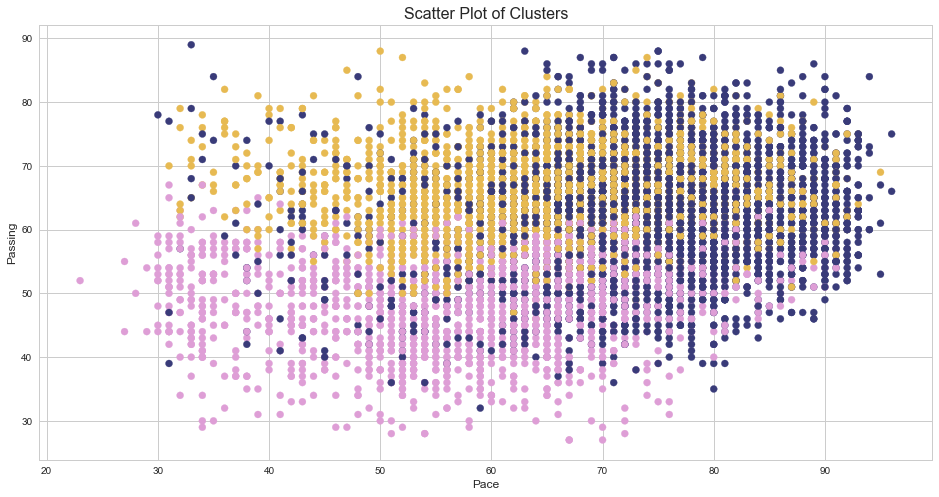

In [99]:
plt.figure(figsize=(16, 8))
plt.scatter(X.Pace, X.Passing, c=clusters, cmap='tab20b')
plt.title('Scatter Plot of Clusters', fontsize=16)
plt.xlabel('Pace', fontsize=12)
plt.ylabel('Passing', fontsize=12)
plt.show()

Comparing pace with passing ability, there is no apparent segmentation of clusters and has a lot of overlap. From this we can draw a conclusion that natural player groupings based on the signicance of the primary attributes will tend to depend more on shooting ability than pace and passing ability.

### Inference and Prediction

#### Robbin's Formula

Robbin's Forumula is an Empirical Bayes method for applying Bayes theorem for say G(x), where x is a parameter that is unknown but exists.  That is to say, it exists as a physical rather than an epistemic distribution taking x to be discrete values.

> "The crucial point, and the surprise, is that *large data sets of parallel situations carry within them their own Bayesian information.*" 
        - Computer Age Statistical Inference, 2016

With this thought in mind, we can go on to explore the data and make further inferences. In our inquiry, we want to find the expected value of player rating ranges in the next time step, that is, the number of players with a particular rating.

In [100]:
# Binning data
bins = [i for i in range(60, 110, 10)]
rating_bins = df.Rating.groupby(pd.cut(df.Rating, bins))
rating_bins.agg([np.mean, np.median, np.size])

mean  median  size
Rating                            
(60, 70]   66.844244      67  5881
(70, 80]   74.077612      74  3685
(80, 90]   83.259887      83   354
(90, 100]  92.333333      92     6

(-500, 7000)

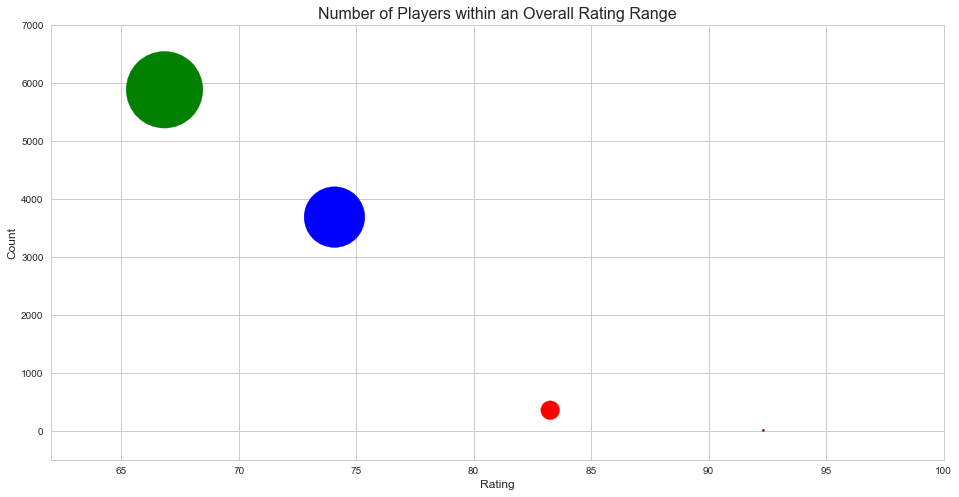

In [101]:
# Plotting the binned data
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1,1,1)
ax.scatter(y=rating_bins.agg([np.size]), x=rating_bins.agg([np.mean]), s=[5881, 3685, 354, 6], 
           color=['green', 'blue', 'red', 'purple'])
plt.title('Number of Players within an Overall Rating Range', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlim((62, 100))
plt.ylim((-500, 7000))

We have put the player ratings into bins or ranges of 10, obtained the mean rating in each range, the median and the number of values in each range.

The player's ratings are grouped as:
>- 5881 players have a rating between 60 and 70 with a median of 67
>- 3685 players have a rating between 70 and 80 with a median on 74
>- 354 players have a rating between 80 and 90 with a median of 83
>- 6 players have a rating between 90 and 100 with a median of 92

We can see that the majority of players have a low rating, while players rated over 90 are fewer than 10. This shows that very few players are able to have a rating that exceeds 90. There are:
>- 10 times more players in the range of 70 - 75, than there are in the range 80 - 90
>- and 50 times more players in the range 90 - 100, than there are in the range 80 - 90,

telling of more competition in the lower ratings range.

In [102]:
# Robbin's Formula
def Robbin(data):
    '''Robbin's Formula implementation to
    estimate the marginal density f(x) as
    a proportion of total counts in category
    x.
            f_hat(x) = y_x/N
    with N = sum(y_x), the total count.
        E[theta|x] = (x + 1)f_hat(x + 1)/f_hat(x)
                   = (x + 1)y_x+1/y_x
    the final expression for the expectation does
    not depend on N.'''
    x = [data.index]
    values = data.values
    N = sum(values)
    expectation = list()
    # Fitting data into a Gamma distribution:
    # Sample normally distributed samples
    #samp = sc.stats.norm.rvs(loc=0,scale=1,size=4)
    #param = sc.stats.norm.fit(samp)
    #'''Where: 
    #         - param[0] is the mean of the fitted model
    #         - param[1] is the standard deviation
    #'''
    #data = sc.stats.norm.pdf(x=values, loc=param[0], scale=param[1])

    for i in zip(x, data, data[1:]):
        x, y_x, y_x_1 = i
        e = ((x + 1) * y_x_1)/y_x
        expectation.append(e)
    return expectation

In [103]:
# Finding the expected value
a = rating_bins.agg([np.median])
a.index = rating_bins.agg([np.size])
Robbin(a['median'])

[Float64Index([[6496.53731343], [4071.10447761], [392.089552239],
               [7.73134328358]],
              dtype='float64')]

(-500, 7500)

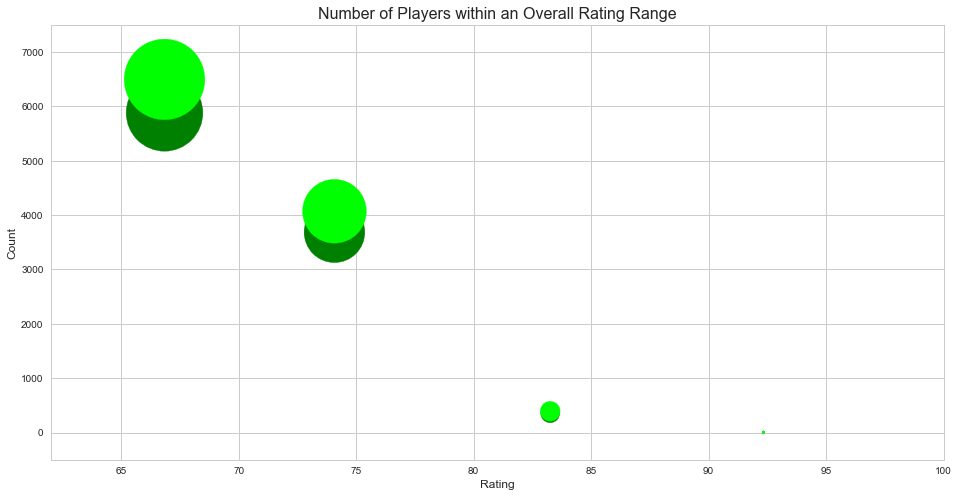

In [104]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1,1,1)
ax.scatter(y=rating_bins.agg([np.size]), x=rating_bins.agg([np.mean]), s=[5881, 3685, 354, 6], color='green')
ax.scatter(y=Robbin(a['median']), x=rating_bins.agg([np.mean]), s=[6497, 4072, 393, 8], color='lime')
plt.title('Number of Players within an Overall Rating Range', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlim((62, 100))
plt.ylim((-500, 7500))

We have now obtained our expectation values in the next time step (coloured lime) based on the ratings (rounded-up):

>- a median rating of 67 (range of 60 - 70) with 5881 players has an expectation of 6497 players
>- a median rating of 74 (range of 70 - 80) with 3685 players has an expectation of 4072 players
>- a median rating of 83 (range of 80 - 90) with 354 players has an expectation of 393 players
>- a median rating of 92 (range of 90 - 100) with 6 players has an expectation of 8 players

So, player numbers are excted to increase in the respective rating ranges.l In this way we have a forecast into player counts as times goes by.

    - Is this estimation an accurate depiction of reality?

Given that there is a quota associated with player registration and the number of players that can be included in Fifa18 Ultimate Team will likely be inhibited by the same ceiling. However, we know that not all registered players of major leagues are recorded in Fifa18 Ultimate Team. We can rest on the logic that the increases may be validated by having the remaining players listed in proceeding version of the game.

### Conclusion

We have seen what the Fifa18 Ultimate Team data looks like, and have seen some instances of data which follow some aspects of reality (loss translation of the term). We have seen the relationship that exists between pace, shooting, passing as well as how important they are in determining the overall rating of a football player regardless of position. The tests we carried out showed the statistical significance of the different attributes and we were also careful to control our biases.

We have classified the players using Hierarchical clustering and observed that player groups based on the observed primary attributes will tend to be dependent on shooting ability than pace and passing. The model build for predicting the expected number of players in the next version or leg of Fifa18 Ultimate Team, based on observed parameters can be used to determine the expectation of the other attributes. From this, we expect to see a great increase in the number of players with a lower overall rating, compared to players with a higher overall rating. And once that data is available, we'll follow up with another exploration exercise and have some fun with data.